## Another idea we explored

### Count number of faces:
As we have manually recorded the number of faces in the posters along with the title position In addition to the title location model  to we fine tuned another VGG-16 Convolutional Neural Network for number of faces. 

The poster preprocessing steps are exactly the same as the title position model, and the last dense layer is modified to predict 11 classes (0 - 9. 10/10+). The batch size is used is 64, which is higher than the title position model because we have a lot model classes. The learn rate is tuned to 1e-3 to achieve better model performance based on the loss rate. Again, descent with momentum 0.9 with a low learning rate to optimize weights and the same loss function were utilized.

In [9]:
#load movie id from 2005-2010
data = pd.read_csv("final_poster_label_2005_2010.csv")
#store movie ID
movieID = data["id"].values

In [4]:
###### read each image and resize 

# total number of posters
n = len(movieID)

# target image size
target_length = 224
target_width = 224

# np.array to store the whole matrix in the order of the movie id
img_matrix = np.zeros([n, target_length, target_width, 3])

for i in range(n):
    if i % 1000 == 0:    
        print (i)    
    
    movie_id = movieID[i]
    
    path = 'posters_2005_2010/' + str(movie_id) + '.jpg'
    
    #read image
    img = cv2.imread(path)
    
    # normalize the image[-1,1], center at 0
    # so that the zero padding does not affect the image
    im = img.astype('float32')
    img = (img - 255/2)/255
    
    # extract the length and width of the image
    img_length, img_width = np.asarray(img.shape[:2])

    
    ## put the image to the center of the array
    # calcuate location of the left edge
    left_loc = int(0.5*(target_width - img_width))
    # calcuate location of the top edge
    top_loc = int(0.5*(target_length - img_length))
    
    # store the image
    img_matrix[i, top_loc:(top_loc+img_length), 
               left_loc:(left_loc+img_width), :] = img
    
print ("Final data shape:")
img_matrix.shape

0
1000
2000
3000
4000
5000
Final data shape:


(5963, 224, 224, 3)

In [5]:
# reformat the data shape
if K.image_data_format() == 'channels_first':
    img_matrix = img_matrix.reshape(n, 3, target_length, target_width)
    input_shape = (3, target_length, target_width)
else:
    img_matrix = img_matrix.reshape(n, target_length, target_width, 3)
    input_shape = (target_length, target_width, 3)

print('data shape:', img_matrix.shape)

data shape: (5963, 224, 224, 3)


In [10]:
# y values: title position
y_face = data["face_count"].values

# # count of different positions
# for value in np.unique(y_face):
#     print ("Value: {}, Count: {}.".format(value, len(y_face[y_face == value])))

In [7]:
#remove nan from both x and y
index = np.where(np.isnan(y_face) == False)
y_face = y_face[index]
print (len(y_face))

img_matrix = img_matrix[index]
print (img_matrix.shape)

5139
(5139, 224, 224, 3)


In [8]:
### split train and test
# shuffle the samples
n = len(y_face)
index = range(n)
shuffle(index)

y_face = y_face[index]
img_matrix = img_matrix[index]

# one-hot-encode y
encoder = LabelEncoder()
encoder.fit(y_face)
y_encoded = encoder.transform(y_face)

# split train and test data
ratio = 0.9
split_num = int(n*ratio)

x_train = img_matrix[:split_num]
x_test = img_matrix[split_num:]

y_train = y_encoded[:split_num]
y_test = y_encoded[split_num:]

In [9]:
# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 64
# this is fixed, we have 10 digits in our data set
num_classes = 11
# number of iterations over the complete training data
epochs = 20

# convert y values to the format for Keras
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [10]:
#load pretrained model - VGG16
base_model =VGG16(weights='imagenet', include_top=False)

x = base_model.output 
x = GlobalAveragePooling2D()(x) # let's add a fully-connected layer 
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x) # and a logistic layer -- let's say we have 200 classes 
predictions = Dense(num_classes, activation='softmax')(x)  # this is the model we will train 
model = Model(inputs=base_model.input, outputs=predictions)

# set the first 15 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:15]:
    layer.trainable = False
    
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [13]:
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

# fine-tune the model
nnet_face = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
#                     callbacks=[earlyStopping], 
                    validation_split=0.1)

Train on 4162 samples, validate on 463 samples
Epoch 1/20
4162/4162 [==============================] - 79s - loss: 0.2659 - acc: 0.9091 - val_loss: 0.2624 - val_acc: 0.9091

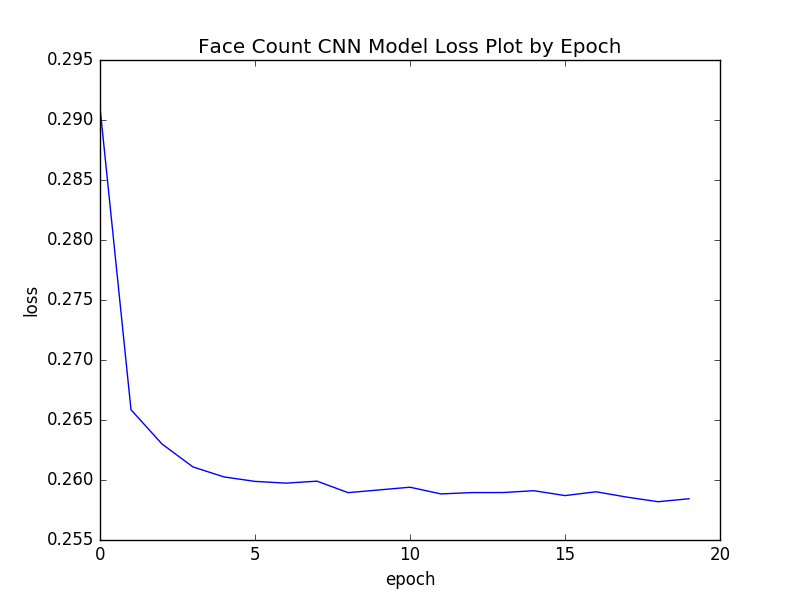

In [5]:
from IPython.display import Image
Image(filename='Loss_Plot.png')

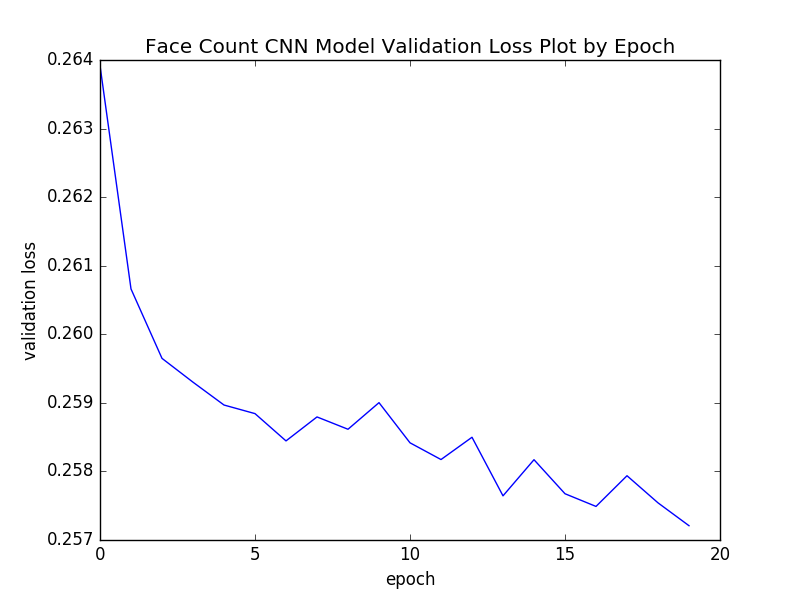

In [6]:
Image(filename='Val_Loss_Plot.png')

### Genre Classification:

In addition, we also attempted to directly classify movie genres using the posters. Because a single movie can be associated with several different genres, this represents a **multi-label classification** problem where we have to adapt binary classifiers to the multi-label scenario. Methods to adapt binary classifiers to the multilabel case include fitting a model on a single label at a time (**One vs Rest Classifier**) and then assigning multiple predicted labels to data points that are predicted to belong to the labeled cases.

We will also incorporate the title position and number of faces to the metadata downloaded from TMDB, and build models to predict genres. We are also trying to extract RGB ratio from the posters, and use it as an additional predictor in the model.


## Conclusions and Future Directions

 - Use neural net from posters to predict genre: plan to do multiple one vs all classifications
 - Incorporate face and titles together with the other data to predict genre
 - Extract RGB ratio from the posters, and incorporate into genre prediction model. 